<a href="https://colab.research.google.com/github/Icaro92/Logistic_regression_Churn_prediction_model_Stephen_Klosterman/blob/main/Chrun_Prediction_model_Stephen_Klosterman.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup e bibliotecas

In [ ]:
#biblioteca para transformação e manipulação de dados
import pandas as pd
import numpy as np

In [ ]:
import matplotlib.pyplot as plt #pacote de plotting
%matplotlib inline
import matplotlib as mpl
import seaborn as sns
mpl.rcParams['figure.dpi'] = 200 #Alta Resolução

In [ ]:
#Bibliotecas de modelagem e ciência de dados
from scipy import stats
from sklearn.feature_selection import f_classif
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn import tree
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

In [ ]:
df = pd.read_excel('/content/default_of_credit_card_clients__courseware_version_1_21_19 (1).xls') #importando base de dados

In [ ]:
df.shape #verificando o tamanho da base de dados

(30000, 25)

# Exploração e limpeza de dados

* Os dados consistem em um mês de informações da conta do cartão de crédito, com dados históricos remontando a seis meses. Uma verificação básica de qualidade é garantir que tenhamos dados para tantas contas quantas pensamos ter. Em particular, os IDs das contas devem ser todos distintos.

In [ ]:
df.columns #verificando as colunas

Index(['ID', 'LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_1',
       'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6',
       'default payment next month'],
      dtype='object')

In [ ]:
df.head() #verificando as primeiras linhas

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,798fc410-45c1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
1,8a8c8f3b-8eb4,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,85698822-43f5,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,0737c11b-be42,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,3b7f77cc-dbc0,50000,1,2,1,57,-1,0,-1,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [ ]:
print(df['ID'].nunique()) #verificando a quantidade de IDs
print(df.shape[0]) #verificando o tamanho da base de dados

# verificamos que o número de linhas e o número de IDs únicos são diferentes, indicado a presença de IDs duplicados.

29687
30000


In [ ]:
id_counts = df['ID'].value_counts() #verificando a quantidade de IDs duplicados
id_counts.head()

ID
ad23fe5c-7b09    2
1fb3e3e6-a68d    2
89f8f447-fca8    2
7c9b7473-cc2f    2
90330d02-82d9    2
Name: count, dtype: int64

In [ ]:
id_counts.value_counts() #verificando que existem 313 IDs duplicados

count
1    29374
2      313
Name: count, dtype: int64

In [ ]:
dupe_mask = id_counts == 2 #criando uma máscara para identificar os IDs duplicados
dupe_mask[0:5]

ID
ad23fe5c-7b09    True
1fb3e3e6-a68d    True
89f8f447-fca8    True
7c9b7473-cc2f    True
90330d02-82d9    True
Name: count, dtype: bool

In [ ]:
id_counts.index[0:5] #verificando os IDs duplicados

Index(['ad23fe5c-7b09', '1fb3e3e6-a68d', '89f8f447-fca8', '7c9b7473-cc2f',
       '90330d02-82d9'],
      dtype='object', name='ID')

In [ ]:
id_counts.index[0:5] #verificando os IDs duplicados
dupe_ids = id_counts.index[dupe_mask] #criando uma lista com os IDs duplicados
dupe_ids = list(dupe_ids) #transformando a lista em uma lista
len(dupe_ids) #verificando a quantidade de IDs duplicados

313

In [ ]:
df.loc[df['ID'].isin(dupe_ids[0:3]),:].head(10)

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
5033,89f8f447-fca8,320000,2,2,1,32,0,0,0,0,...,169371,172868,150827,8000,8000,5500,6100,6000,5000,0
5133,89f8f447-fca8,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
16727,1fb3e3e6-a68d,80000,1,2,2,33,2,2,0,0,...,27394,29922,31879,0,2000,2000,3000,2600,0,1
16827,1fb3e3e6-a68d,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
29685,ad23fe5c-7b09,50000,1,3,1,32,0,0,0,0,...,12882,8131,3983,3000,2871,1000,163,3983,3771,1
29785,ad23fe5c-7b09,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


* Podemos ver alguns IDs duplicados aqui, e parece que cada ID duplicado tem uma linha com dados e outra linha com todos os zeros. Isso ocorre para cada ID duplicado? Vamos verificar.

In [ ]:
df_zero_mask = df == 0 #criando uma máscara para identificar os zeros

In [ ]:
feature_zero_mask = df_zero_mask.iloc[:,1:].all(axis=1) #criando uma máscara para identificar as colunas com todos os zeros

In [ ]:
sum(feature_zero_mask)

315

* temos pelo menos uma quantidade próxima de IDs duplicados e número linhas zeradas no dataset, vamos remover as linhas zero e verificar se ainda temos ids duplicados após.

In [ ]:
df_clean_1 = df.loc[~feature_zero_mask,:].copy() #removendo as linhas com todos os zeros
df_clean_1.shape

(29685, 25)

In [ ]:
df_clean_1['ID'].nunique() #verificando a quantidade de IDs
# Deu certo! O número de Ids únicos é igual ao número de linhas - indicando que não há mais IDs duplicados.

29685

# Explorando as caractertísticas dos dados

In [ ]:
df_clean_1.info() # Verificamos que ID e PAY_1 estão como Object. Enquanto está tudo ok para ID, PAY_1 deveria ser Int64

<class 'pandas.core.frame.DataFrame'>
Index: 29685 entries, 0 to 29999
Data columns (total 25 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   ID                          29685 non-null  object
 1   LIMIT_BAL                   29685 non-null  int64 
 2   SEX                         29685 non-null  int64 
 3   EDUCATION                   29685 non-null  int64 
 4   MARRIAGE                    29685 non-null  int64 
 5   AGE                         29685 non-null  int64 
 6   PAY_1                       29685 non-null  object
 7   PAY_2                       29685 non-null  int64 
 8   PAY_3                       29685 non-null  int64 
 9   PAY_4                       29685 non-null  int64 
 10  PAY_5                       29685 non-null  int64 
 11  PAY_6                       29685 non-null  int64 
 12  BILL_AMT1                   29685 non-null  int64 
 13  BILL_AMT2                   29685 non-null  int64 


In [ ]:
df_clean_1.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,798fc410-45c1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
1,8a8c8f3b-8eb4,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,85698822-43f5,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,0737c11b-be42,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,3b7f77cc-dbc0,50000,1,2,1,57,-1,0,-1,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [ ]:
df_clean_1['PAY_1'].head(5)

0     2
1    -1
2     0
3     0
4    -1
Name: PAY_1, dtype: object

In [ ]:
df_clean_1['PAY_1'].value_counts() # será necessário tratar os dados e retirar o 'Not available'

PAY_1
0                13087
-1                5047
1                 3261
Not available     3021
-2                2476
2                 2378
3                  292
4                   63
5                   23
8                   17
6                   11
7                    9
Name: count, dtype: int64

In [ ]:
valid_pay_1_mask = df_clean_1['PAY_1'] != 'Not available' #criando uma máscara para identificar os valores válidos de PAY_1

In [ ]:
valid_pay_1_mask[0:5]

0    True
1    True
2    True
3    True
4    True
Name: PAY_1, dtype: bool

In [ ]:
sum(valid_pay_1_mask)

26664

In [ ]:
df_clean_2 = df_clean_1.loc[valid_pay_1_mask,:].copy() #removendo as linhas com PAY_1 = Not available

In [ ]:
df_clean_2.shape

(26664, 25)

In [ ]:
df_clean_2['PAY_1'].value_counts()

PAY_1
0     13087
-1     5047
1      3261
-2     2476
2      2378
3       292
4        63
5        23
8        17
6        11
7         9
Name: count, dtype: int64

In [ ]:
df_clean_2['PAY_1'] = df_clean_2['PAY_1'].astype('int64') #Alterando o tipo de dado de Pay_1

In [ ]:
df_clean_2[['PAY_1', 'PAY_2']].info() #funcionou!

<class 'pandas.core.frame.DataFrame'>
Index: 26664 entries, 0 to 29999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   PAY_1   26664 non-null  int64
 1   PAY_2   26664 non-null  int64
dtypes: int64(2)
memory usage: 624.9 KB


* Explorando Limite de Crédito e demográficos

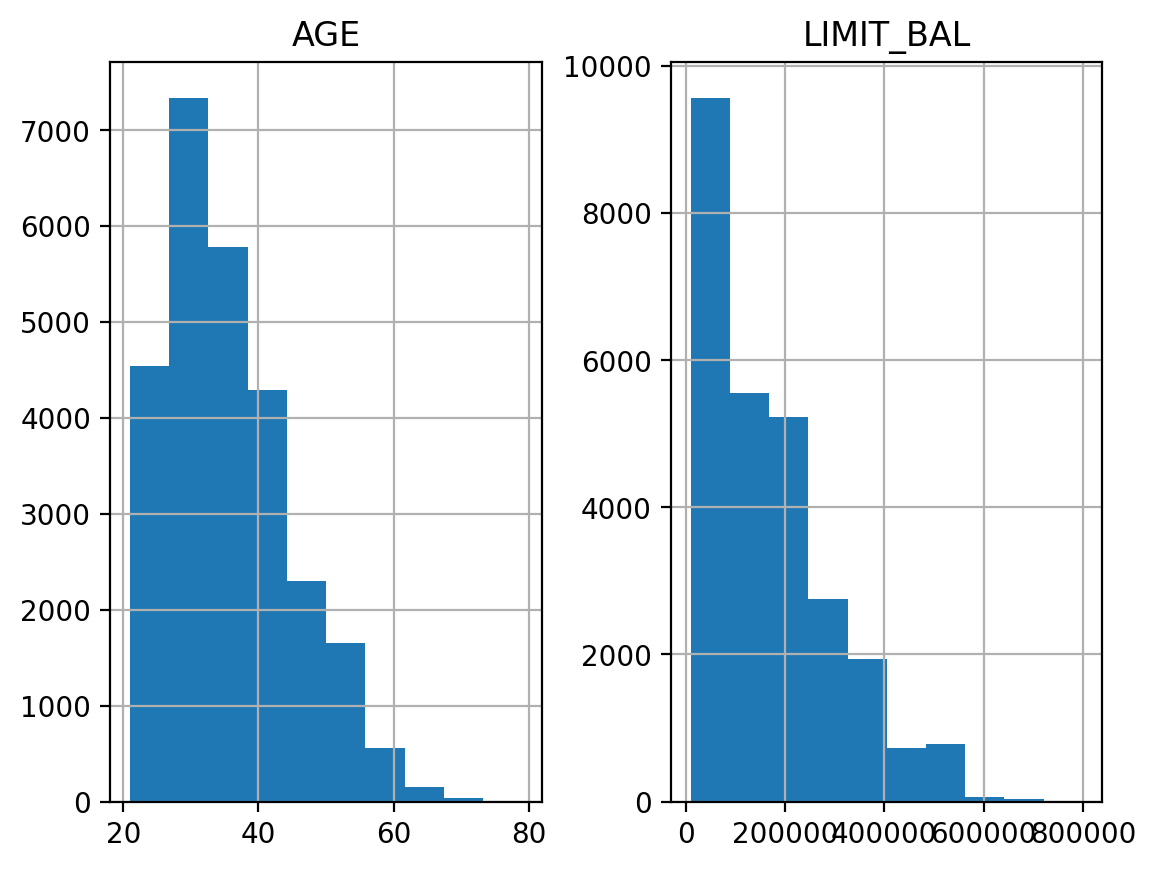

In [ ]:
df_clean_2[['AGE','LIMIT_BAL']].hist();

In [ ]:
df_clean_2[['LIMIT_BAL', 'AGE']].describe()

,LIMIT_BAL,AGE
count,26664.000000,26664.000000
mean,167919.054905,35.505213
std,129839.453081,9.227442
min,10000.000000,21.000000
25%,50000.000000,28.000000
50%,140000.000000,34.000000
75%,240000.000000,41.000000
max,800000.000000,79.000000


In [ ]:
df_clean_2['EDUCATION'].value_counts()

EDUCATION
2    12458
1     9412
3     4380
5      245
4      115
6       43
0       11
Name: count, dtype: int64

* Recebemos o dicionário de que "Education (1 = graduate school; 2 = university; 3 = high school; 4 = others)"
Assim, vamos mudar as categorias.

In [ ]:
df_clean_2['EDUCATION'].replace(to_replace=[0, 5, 6], value=4, inplace=True) #mudando não identificados para 'others'

In [ ]:
df_clean_2['EDUCATION'].value_counts() #funcionou!

EDUCATION
2    12458
1     9412
3     4380
4      414
Name: count, dtype: int64

In [ ]:
df_clean_2['MARRIAGE'].value_counts()

MARRIAGE
2    14158
1    12172
3      286
0       48
Name: count, dtype: int64

In [ ]:
#Deveria ser apenas (1 = married; 2 = single; 3 = others).
df_clean_2['MARRIAGE'].replace(to_replace=0, value=3, inplace=True) #substituindo os valores

In [ ]:
df_clean_2['MARRIAGE'].value_counts() #funcionou!

MARRIAGE
2    14158
1    12172
3      334
Name: count, dtype: int64

## Deep Dive - variáveis categóricas

In [ ]:
df_clean_2['EDUCATION'].head()

0    2
1    2
2    2
3    2
4    2
Name: EDUCATION, dtype: int64

In [ ]:
df_clean_2.groupby('EDUCATION').agg({'default payment next month':'mean'}) #agrupando por education para verificar os diferentes níveis de uma carac

,default payment next month
EDUCATION,
1,0.193901
2,0.235913
3,0.255479
4,0.074879


Text(0.5, 0, 'Education level: ordinal encoding')

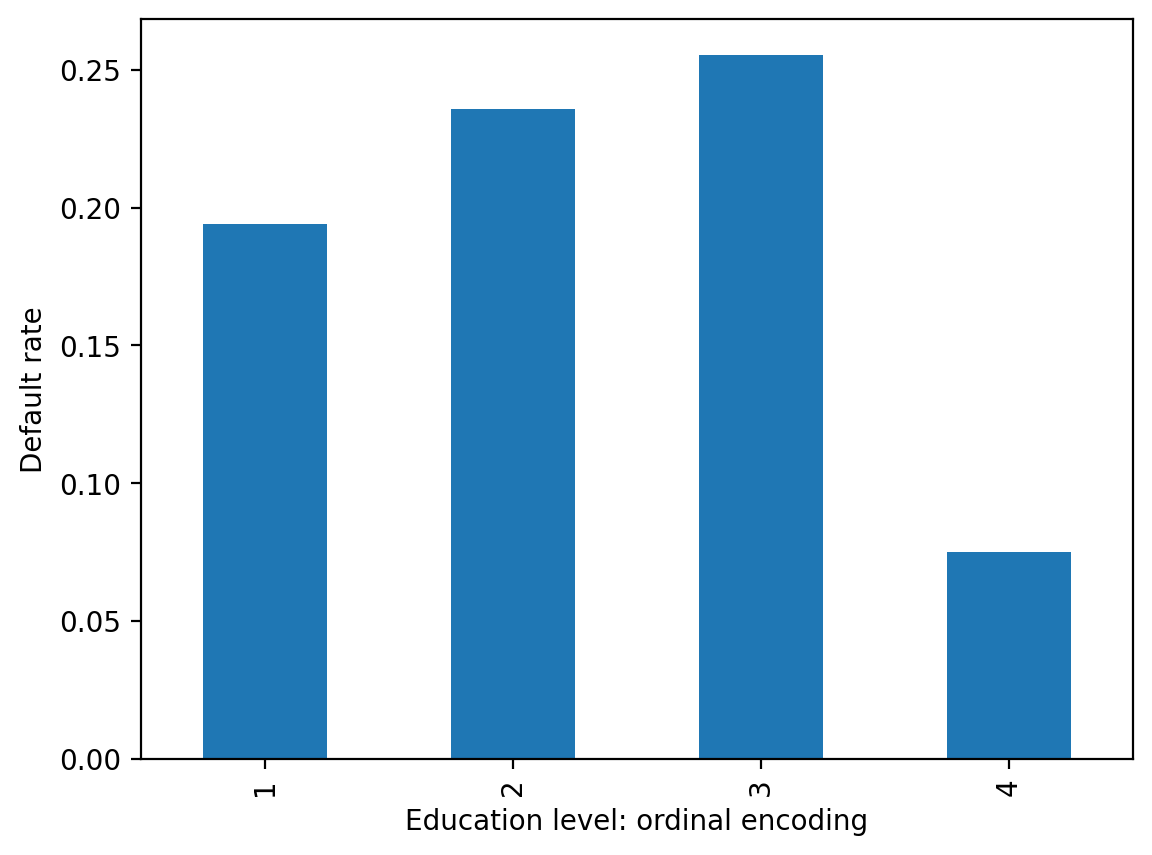

In [ ]:
df_clean_2.groupby('EDUCATION').agg({'default payment next month':'mean'}).plot.bar(legend=False)
plt.ylabel('Default rate')
plt.xlabel('Education level: ordinal encoding')

* vamos utilziar o One_hot_enconding para fazermos a preparação de dados categóricos

In [ ]:
df_clean_2['EDUCATION_CAT'] = 'none' #criar uma nova coluna para receber os valores posteriormente

In [ ]:
df_clean_2[['EDUCATION', 'EDUCATION_CAT']].head(10)

,EDUCATION,EDUCATION_CAT
0,2,none
1,2,none
2,2,none
3,2,none
4,2,none
5,1,none
6,1,none
7,2,none
8,3,none
9,3,none


In [ ]:
#mapeando as caractérísticas:
cat_mapping = {
    1: "graduate school",
    2: "university",
    3: "high school",
    4: "others"
}

In [ ]:
df_clean_2['EDUCATION_CAT'] = df_clean_2['EDUCATION'].map(cat_mapping) #aplicando o mapeamento

In [ ]:
df_clean_2[['EDUCATION', 'EDUCATION_CAT']].head(10) #dataset com as características mapeadas e prontas para utilizarmos o encoding.

,EDUCATION,EDUCATION_CAT
0,2,university
1,2,university
2,2,university
3,2,university
4,2,university
5,1,graduate school
6,1,graduate school
7,2,university
8,3,high school
9,3,high school


In [ ]:
edu_ohe = pd.get_dummies(df_clean_2['EDUCATION_CAT'])
edu_ohe.head(10)
#consideramos False como 0 e True como 1

,graduate school,high school,others,university
0,False,False,False,True
1,False,False,False,True
2,False,False,False,True
3,False,False,False,True
4,False,False,False,True
5,True,False,False,False
6,True,False,False,False
7,False,False,False,True
8,False,True,False,False
9,False,True,False,False


In [ ]:
df_with_ohe = pd.concat([df_clean_2, edu_ohe], axis=1)
df_with_ohe[['EDUCATION_CAT', 'graduate school',
             'high school', 'university', 'others']].head(10)

,EDUCATION_CAT,graduate school,high school,university,others
0,university,False,False,True,False
1,university,False,False,True,False
2,university,False,False,True,False
3,university,False,False,True,False
4,university,False,False,True,False
5,graduate school,True,False,False,False
6,graduate school,True,False,False,False
7,university,False,False,True,False
8,high school,False,True,False,False
9,high school,False,True,False,False


In [ ]:
#Exportar o dataset:
# df_with_ohe.to_csv('../Data/Cleaned_data.csv', index=False)

# Explorando as features dos dados

In [ ]:
df = pd.read_csv('/content/Chapter_1_cleaned_data.csv') #importando o novo DF LIMPO da primeira etapa

In [ ]:
df.columns

Index(['ID', 'LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_1',
       'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6',
       'default payment next month', 'EDUCATION_CAT', 'graduate school',
       'high school', 'others', 'university'],
      dtype='object')

Colunas de pagamento são aquelas entre Pay_1 e Pay_6. Vamos explorá-las:

In [ ]:
pay_feats = ['PAY_1', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']

In [ ]:
df[pay_feats].describe()

,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6
count,26664.000000,26664.000000,26664.000000,26664.000000,26664.000000,26664.000000
mean,-0.017777,-0.133363,-0.167679,-0.225023,-0.269764,-0.293579
std,1.126769,1.198640,1.199165,1.167897,1.131735,1.150229
min,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000
25%,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000


In [ ]:
df[pay_feats[0]].value_counts().sort_index()

PAY_1
-2     2476
-1     5047
 0    13087
 1     3261
 2     2378
 3      292
 4       63
 5       23
 6       11
 7        9
 8       17
Name: count, dtype: int64

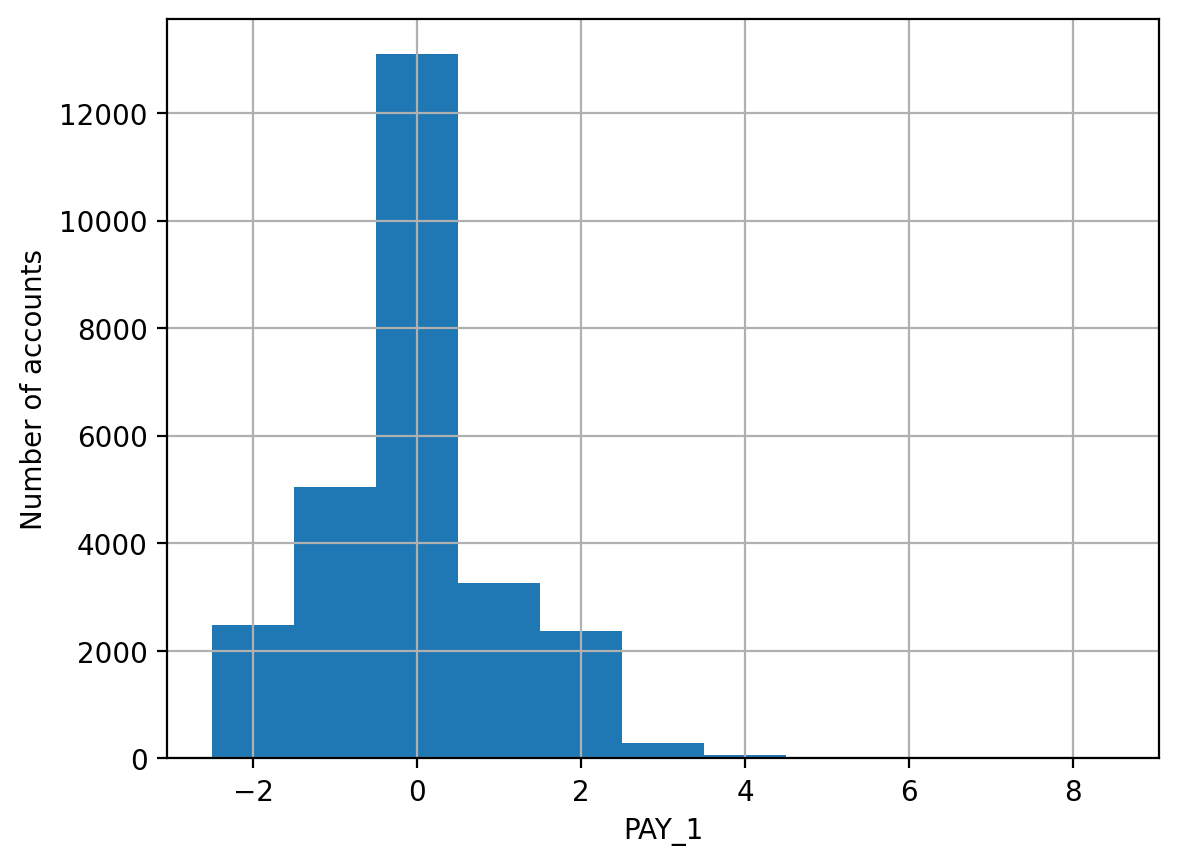

In [ ]:
pay_1_bins = np.array(range(-2,10)) - 0.5
df[pay_feats[0]].hist(bins=pay_1_bins)
plt.xlabel('PAY_1')
plt.ylabel('Number of accounts');


* Aqui vemos que a maioria das contas está em boa situação, Entre -2,1 e 0, o que indica que a maioria das pessoas está pagando suas dívidas com pouco ou nenhum atraso.
* vamos examinar outras características

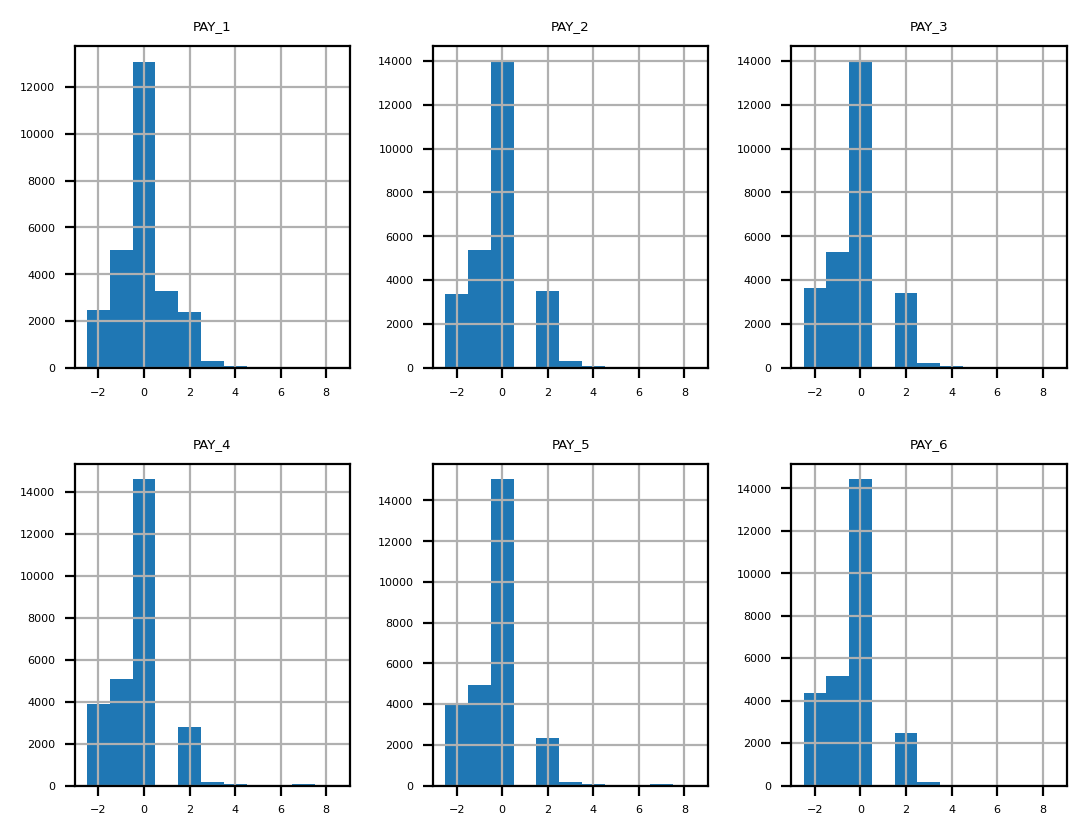

In [ ]:
mpl.rcParams['font.size'] = 4
df[pay_feats].hist(bins=pay_1_bins, layout=(2,3));

* Percebemos que os dados estão incorretos ou imcompletos para PAY_2 a PAY_6 e entramos em contato com o cliente.
* O cliente confirmou que os dados estão faltantes e que ele está trabalho para realizar a atualização, mas que isso só acontecerá após o próximo mês.
* Por agora iremos trabalhar com esses dados ausentes

In [ ]:
bill_feats = ['BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6']
pay_amt_feats = ['PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']

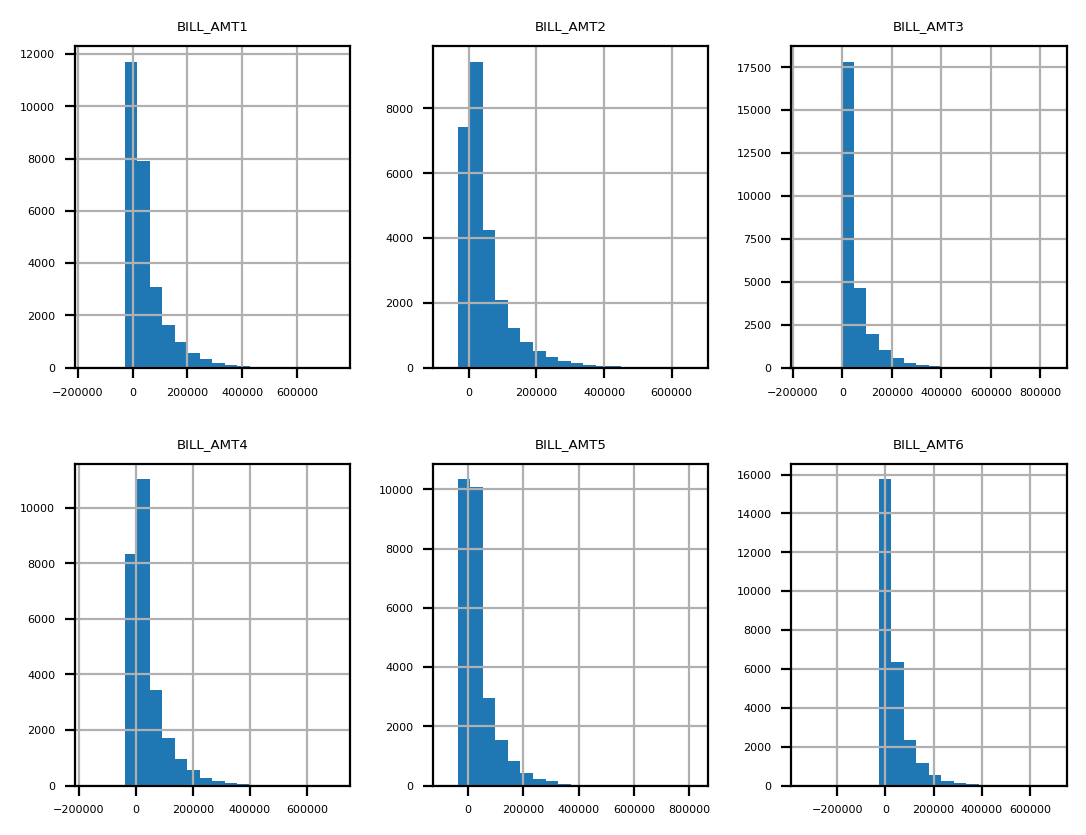

In [ ]:
df[bill_feats].hist(bins=20, layout=(2,3));

In [ ]:
df[bill_feats].describe()

,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6
count,26664.000000,26664.000000,26664.000000,26664.000000,26664.000000,26664.000000
mean,51405.730723,49300.001500,47026.340047,43338.894539,40338.136701,38889.872337
std,73633.687106,70934.549534,68705.359524,64275.250740,60705.944083,59432.541657
min,-165580.000000,-69777.000000,-157264.000000,-170000.000000,-81334.000000,-339603.000000
25%,3580.000000,2999.750000,2627.250000,2341.750000,1745.000000,1256.000000
50%,22361.000000,21150.000000,20079.500000,19037.000000,18066.000000,17005.000000
75%,67649.750000,64395.500000,60360.000000,54727.500000,50290.500000,49253.750000
max,746814.000000,671563.000000,855086.000000,706864.000000,823540.000000,699944.000000


array([[<Axes: title={'center': 'PAY_AMT1'}>,
        <Axes: title={'center': 'PAY_AMT2'}>,
        <Axes: title={'center': 'PAY_AMT3'}>],
       [<Axes: title={'center': 'PAY_AMT4'}>,
        <Axes: title={'center': 'PAY_AMT5'}>,
        <Axes: title={'center': 'PAY_AMT6'}>]], dtype=object)

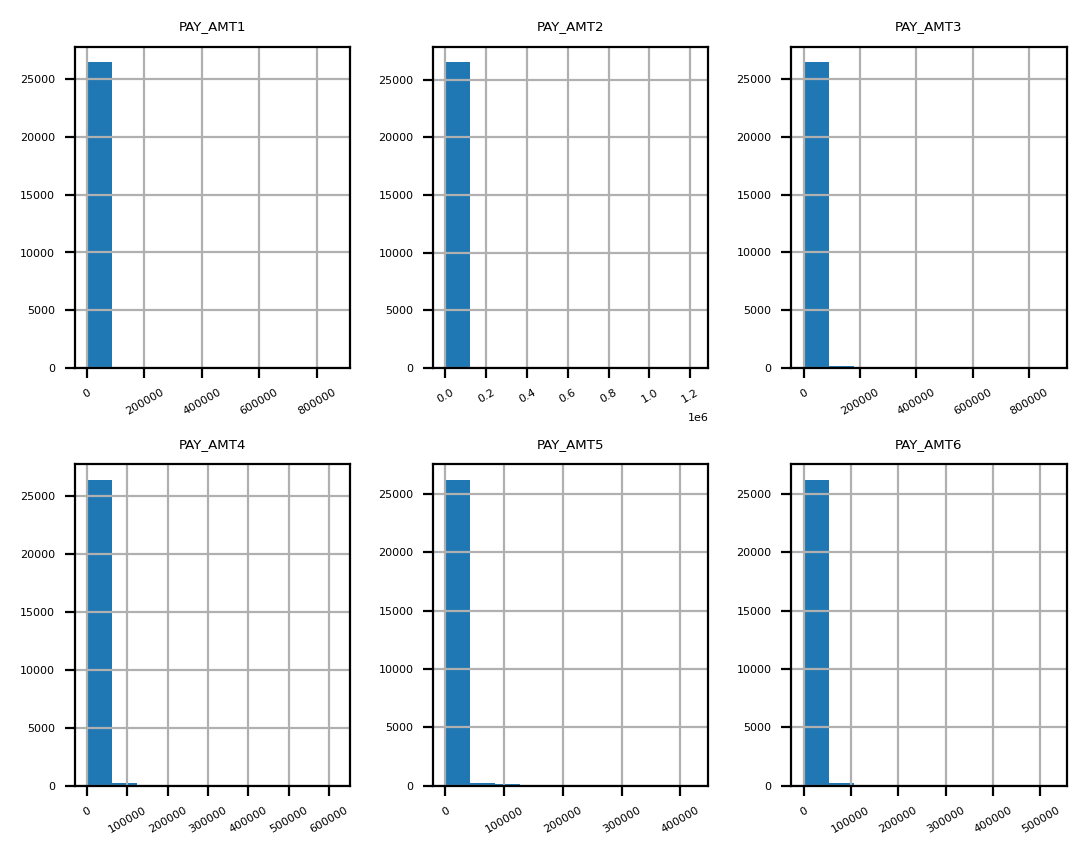

In [ ]:
df[pay_amt_feats].hist(layout=(2,3), xrot=30)

In [ ]:
df[pay_amt_feats].describe()

,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
count,26664.000000,2.666400e+04,26664.000000,26664.000000,26664.000000,26664.000000
mean,5704.085771,5.881110e+03,5259.514964,4887.048717,4843.729973,5257.843047
std,16699.398632,2.121431e+04,17265.439561,15956.349371,15311.721795,17635.468185
min,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000
25%,1000.000000,8.020000e+02,390.000000,294.750000,242.750000,111.000000
50%,2114.500000,2.007000e+03,1822.000000,1500.000000,1500.000000,1500.000000
75%,5027.000000,5.000000e+03,4556.250000,4050.500000,4082.750000,4015.000000
max,873552.000000,1.227082e+06,889043.000000,621000.000000,426529.000000,528666.000000


Aparentemente, está tudo bem com as outras características. E vamos explorar a agora a relação delas com a nossa característica alvo 'Default payment next month'


## Examinando a relação entre as características

In [ ]:
features_response = df.columns.tolist() #

In [ ]:
features_response[:5] #verificando as colunas

['ID', 'LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE']

In [ ]:
features_response[-5:] #verificando o conteúdo colunas

['EDUCATION_CAT', 'graduate school', 'high school', 'others', 'university']

In [ ]:
items_to_remove = ['ID', 'SEX', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6',
                   'EDUCATION_CAT', 'graduate school', 'high school', 'none',
                   'others', 'university']

# vamos remover todas as PAY features que tiveram problemas conforme relatamos anteriormente. E também a educação por conta de requisição do cliente

In [ ]:
# removendo os itens da lista
features_response = [item for item in features_response if item not in items_to_remove]
features_response

['LIMIT_BAL',
 'EDUCATION',
 'MARRIAGE',
 'AGE',
 'PAY_1',
 'BILL_AMT1',
 'BILL_AMT2',
 'BILL_AMT3',
 'BILL_AMT4',
 'BILL_AMT5',
 'BILL_AMT6',
 'PAY_AMT1',
 'PAY_AMT2',
 'PAY_AMT3',
 'PAY_AMT4',
 'PAY_AMT5',
 'PAY_AMT6',
 'default payment next month']

## Correlação

In [ ]:
#gerando a correlação entre as caractertísticas. Nossa variavel target é 'default payment next month'
corr = df[features_response].corr()
corr.iloc[0:5,0:5]

,LIMIT_BAL,EDUCATION,MARRIAGE,AGE,PAY_1
LIMIT_BAL,1.000000,-0.232688,-0.111873,0.149157,-0.273396
EDUCATION,-0.232688,1.000000,-0.137097,0.179035,0.112653
MARRIAGE,-0.111873,-0.137097,1.000000,-0.412828,0.019759
AGE,0.149157,0.179035,-0.412828,1.000000,-0.044277
PAY_1,-0.273396,0.112653,0.019759,-0.044277,1.000000


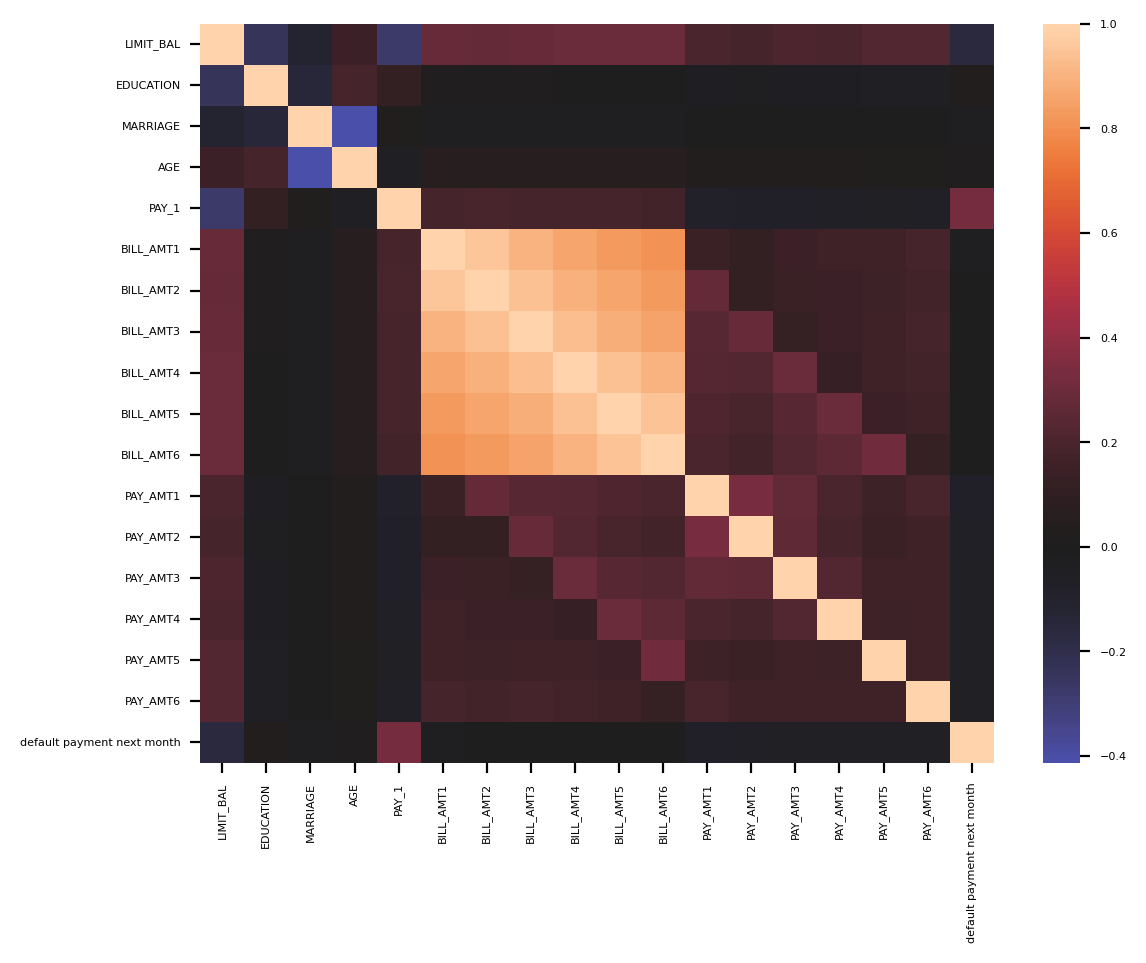

In [ ]:
# conseguimos observar melhor gráficamente:
mpl.rcParams['figure.dpi'] = 200 #high res figures
sns.heatmap(corr,
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values,
            center=0);

* Verificamos que a única variável que está fortemente correlacionada com nossa variável target 'default payment next month' é a variável PAY_1.

* Vamos realizar um F-test para fazer a seleção de variáveis


## Teste F para seleção de variáveis

In [ ]:
X = df[features_response].iloc[:,:-1].values
y = df[features_response].iloc[:,-1].values
print(X.shape, y.shape)

(26664, 17) (26664,)


In [ ]:
[f_stat, f_p_value] = f_classif(X, y)

In [ ]:
f_test_df = pd.DataFrame({'Feature':features_response[:-1],
                          'F statistic':f_stat,
                          'p value':f_p_value})
f_test_df.sort_values('p value')

,Feature,F statistic,p value
4,PAY_1,3156.672300,0.000000e+00
0,LIMIT_BAL,651.324071,5.838366e-142
11,PAY_AMT1,140.612679,2.358354e-32
12,PAY_AMT2,101.408321,8.256124e-24
13,PAY_AMT3,90.023873,2.542641e-21
15,PAY_AMT5,85.843295,2.090120e-20
16,PAY_AMT6,80.420784,3.219565e-19
14,PAY_AMT4,79.640021,4.774112e-19
1,EDUCATION,32.637768,1.122175e-08
2,MARRIAGE,18.078027,2.127555e-05


In [ ]:
from sklearn.feature_selection import SelectPercentile
selector = SelectPercentile(f_classif, percentile=20)

In [ ]:
selector.fit(X, y)

SelectPercentile(percentile=20)

In [ ]:
best_feature_ix = selector.get_support()
best_feature_ix

array([ True, False, False, False,  True, False, False, False, False,
       False, False,  True,  True, False, False, False, False])

In [ ]:
features = features_response[:-1]

In [ ]:
best_features = [features[counter] for counter in range(len(features))
                 if best_feature_ix[counter]]
best_features

['LIMIT_BAL', 'PAY_1', 'PAY_AMT1', 'PAY_AMT2']

# Aplicação de Modelos Preditivos

* Agora que conhecemos as features, vamos tentar encontrar um ótimo modelo para nossos dados

## Modelo 1: Regressão Logistica
 * Utilizaremos as top 5 features que encontramos no Teste-F

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df[best_features].values, df['default payment next month'].values, test_size=0.2, random_state=24) #dividindo os dados em treino e teste (80/20)

In [ ]:
lr_model = LogisticRegression(solver='liblinear') #modelo de regressão logística
lr_model.fit(X_train, y_train) #treinando o modelo

LogisticRegression(solver='liblinear')

In [ ]:
y_pred = lr_model.predict(X_test) #predição com o model
y_pred_proba = lr_model.predict_proba(X_test)[:, 1] #probabilidade de predição como meio de avaliação

In [ ]:
print(lr_model.coef_ , lr_model.intercept_) #coeficientes e intercepto

[[-5.53809649e-06  5.89736452e-08 -2.87494843e-05 -2.36663865e-05]] [-2.50486628e-08]


In [ ]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba) #validando o teste e o predict em True Positive(TPR) e False Positive (FPR)
roc_auc = auc(fpr, tpr)

In [ ]:
roc_auc_score(y_test, y_pred_proba) #avaliação do modelo

0.637467853671779

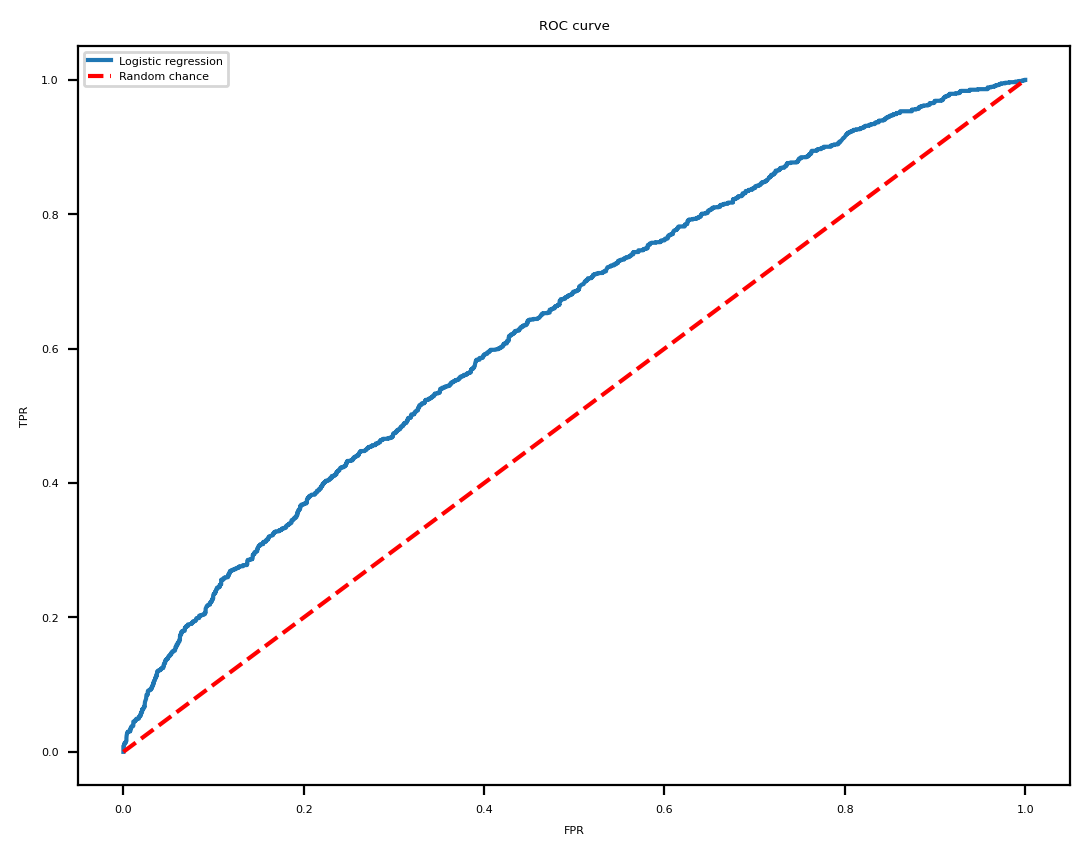

In [ ]:
plt.plot(fpr, tpr, )
plt.plot([0, 1], [0, 1], 'r--')
plt.legend(['Logistic regression', 'Random chance'])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC curve');

## Deu certo?
* Atualmente o modelo ROC_AUC = 0,64 e é apenas um pouco melhor que o acaso, isto é 50%
* Sendo assim, vamos tentar algumas alterações para melhor a eficiência do modelo para isso, vamos utilizar a validação cruzada e engenharia de alguns hiperparâmetros


## Modelo 2: Regressão Logística + Validação Cruzada e Tuning de HiperParametros

* Dessa vez, vamos utilizar o conceito de validação cruzada para encontrar um bom valor para o hiperparâmetro *C*
 C é o parâmetro de regularização

In [ ]:
# Selecionaremos as caractrísticas do DF
features = features_response[:-1] #retiramos a variável resposta
X = df[features].values
y = df['default payment next month'].values

In [ ]:
# Nova separação entre Train e Test:
X_train, X_test, y_train, y_test = train_test_split(X, df['default payment next month'].values,
                                                    test_size = 0.2,
                                                    random_state= 24)

In [ ]:
# Escalonar os dados com o MinMaxScaler
from sklearn.preprocessing import MinMaxScaler
min_max_sc = MinMaxScaler()

Aqui serão utilizados alguns hiperparâmetros:
* Solver = 'saga'
* Penalty = L1 (Lasso)
* Max_Iter = 1000

In [ ]:
# Instanciar um modleo de regressão logistica ocm o solver **saga** e a penalty = l1, com max_iter = 1000 (para termos varias interações pro solver encontrar uma boa solução)
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(solver='saga',
                        penalty='l1',
                        max_iter=1000)


In [ ]:
# Importar a classe Pipeline e criar um escalonador e o modelo de regressão logística usando os nomes scaler e model

from sklearn.pipeline import Pipeline

scale_lr_pipeline = Pipeline(steps=[('scaler', min_max_sc), ('model', lr)])

In [ ]:
# Utilizando métodos get_params e set_params para visualizar os parametros de cada estágio do pipeline e altera-los se necessário

scale_lr_pipeline.get_params()
scale_lr_pipeline.get_params()['model__C']
scale_lr_pipeline.set_params(model__C = 2)

Pipeline(steps=[('scaler', MinMaxScaler()),
                ('model',
                 LogisticRegression(C=2, max_iter=1000, penalty='l1',
                                    solver='saga'))])

In [ ]:
# Aqui quero criar un intervalo menor valores de C para testar com a validação cruzada. Utilizei: C = [10², 10¹, 1, 10-¹, 10-², 10-³]

C_val_exponents = np.linspace(2,-3,6) # Valores de C = [10², 10¹, 1, 10-¹, 10-², 10-³]
C_vals = 10**C_val_exponents
C_vals

array([1.e+02, 1.e+01, 1.e+00, 1.e-01, 1.e-02, 1.e-03])

In [ ]:
# Essa função é criada e encontrada segundo o livro "Projeto de ciência de dados com Python - Stephen Klosterman"
# encontrada em https://github.com/TrainingByPackt/Data-Science-Projects-with-Python/blob/master/Lesson04/Lesson04.ipynb

# Por essa razão, as definições estão em inglês.

# A função irá:
  # Receber o
  #Criar um array NumPy para armazenar os valores de teste de C_vals com as dimensões n_folds por len(c_vals)
  #criar uma lista vazia usando [[]] e len(c_Vals). Isso implica que deve haver uma lista de tuplas com métricas True Positive (TPR) e False Positive (FPR)
  #Nessa etapa, a função percorre diferentes folds e realiza a validação cruzada.
  #Cria um loop externo para testar cada um dos kfolds para cada valor de C
  # Obteremos os indices de treinamento e teste de cada kfold (train_index, test_index)
  # Utiliza as características e a variável resposta para treinar o modelo
  # Irá obert os resultados ROC_AUC de Treino e Teste

def cross_val_C_search_pipe(k_folds, C_vals, pipeline, X, Y):

    n_folds = k_folds.n_splits
    cv_train_roc_auc = np.empty((n_folds, len(C_vals)))
    cv_test_roc_auc = np.empty((n_folds, len(C_vals)))
    cv_test_roc = [[]]*len(C_vals)

    for c_val_counter in range(len(C_vals)):
        #Set the C value for the model object
        pipeline.set_params(model__C = C_vals[c_val_counter])
        #Count folds for each value of C
        fold_counter = 0
        #Get training and testing indices for each fold
        for train_index, test_index in k_folds.split(X, Y):
            #Subset the features and response, for training and testing data for
            #this fold
            X_cv_train, X_cv_test = X[train_index], X[test_index]
            y_cv_train, y_cv_test = Y[train_index], Y[test_index]

            #Fit the model on the training data
            pipeline.fit(X_cv_train, y_cv_train)

            #Get the training ROC AUC
            y_cv_train_predict_proba = pipeline.predict_proba(X_cv_train)
            cv_train_roc_auc[fold_counter, c_val_counter] = \
            roc_auc_score(y_cv_train, y_cv_train_predict_proba[:,1])

            #Get the testing ROC AUC
            y_cv_test_predict_proba = pipeline.predict_proba(X_cv_test)
            cv_test_roc_auc[fold_counter, c_val_counter] = \
            roc_auc_score(y_cv_test, y_cv_test_predict_proba[:,1])

            #Testing ROC curves for each fold
            this_fold_roc = roc_curve(y_cv_test, y_cv_test_predict_proba[:,1])
            cv_test_roc[c_val_counter].append(this_fold_roc)

            #Increment the fold counter
            fold_counter += 1

        #Indicate progress
        print('Done with C = {}'.format(pipeline.get_params()['model__C']))

    return cv_train_roc_auc, cv_test_roc_auc, cv_test_roc

In [ ]:
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold

n_folds = 4 #utilizo n_folds = 4 pois quero que cada fold tenha 25% (1/4) dos dados
# esses folds serão os dados de teste de treinamento do modelo (25%) e o restante (75%) de cada fold será utilizado para treinra o modelo
k_folds = KFold(n_splits=n_folds, shuffle=False)

In [ ]:
# Utilizaremos a função para o nosso pipeline e intervalo de C

cv_train_roc_auc, cv_test_roc_auc, cv_test_roc = \
cross_val_C_search_pipe(k_folds, C_vals, scale_lr_pipeline, X_train, y_train)

Done with C = 100.0
Done with C = 10.0
Done with C = 1.0
Done with C = 0.1
Done with C = 0.01
Done with C = 0.001


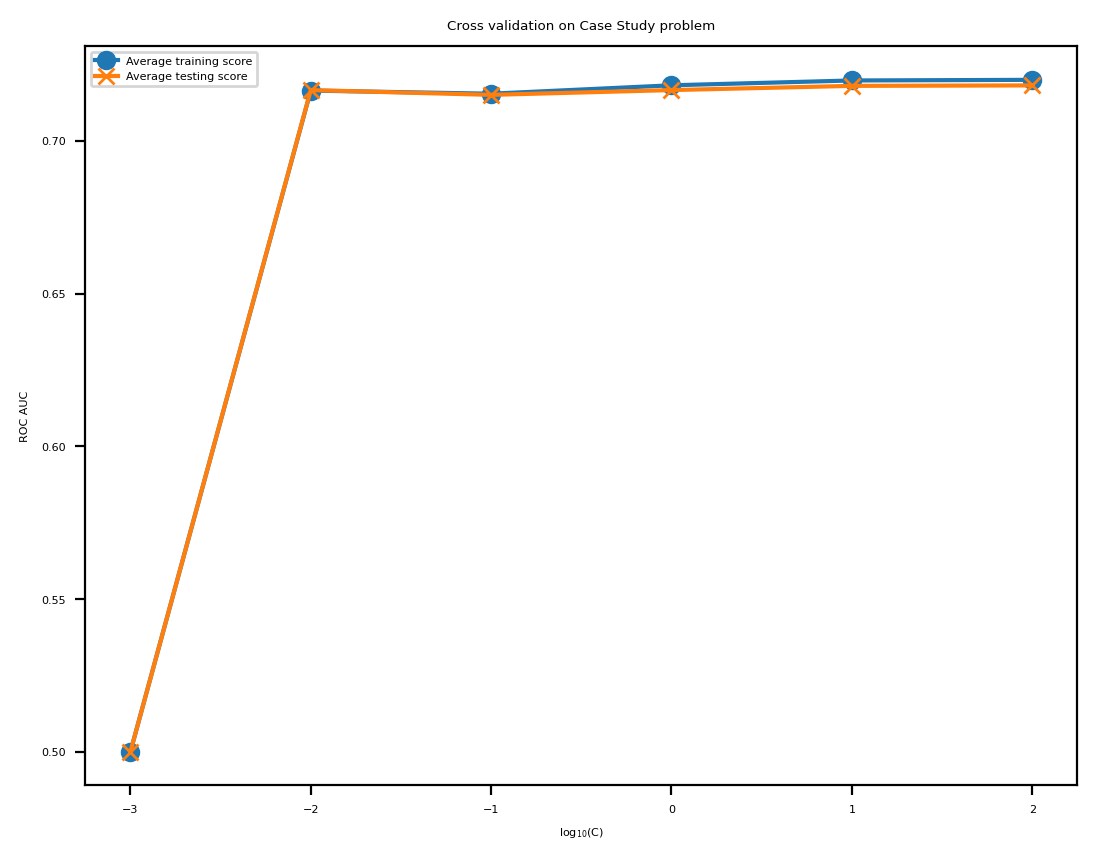

In [ ]:
#10 plotando a ROC AUC média de treinamento e teste entre os FOLDS para cada valor de C:

plt.plot(C_val_exponents, np.mean(cv_train_roc_auc, axis=0), '-o',
        label='Average training score')
plt.plot(C_val_exponents, np.mean(cv_test_roc_auc, axis=0), '-x',
        label='Average testing score')
plt.ylabel('ROC AUC')
plt.xlabel('log$_{10}$(C)')
plt.legend()
plt.title('Cross validation on Case Study problem');

## Lidando com UNDERFITTING
* Aqui, com as pontuações de treinamento e teste estão iguais, temos UNDERFITTING
* Para lidar com o UNDERFITTING, teremos que criar Features de de interação por engenharia para ver se elas podem melhorar o desempenho

In [ ]:
from sklearn.preprocessing import PolynomialFeatures
#Criarremso features de interação para os dados de estudo:

make_interactions = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
#Queremos criar uma característica que seja resultado da interação de 2 das outras características. E testar todas as combinações possíveis nesse caso.
X_interact = make_interactions.fit_transform(X)
print(X_train.shape)
print(X_test.shape)

(21331, 17)
(5333, 17)


* Temos agora 153 características, isto é, nossas 17 + "17 escolha 2" = 17 + 136 = 153
* A parte "17 escolha 2" vem da seleção de todas as combinações possíveis de 2 características para interagir a partir das 17 características possíveis

In [ ]:
# Aqui separamos o novo dataset com 153 características em treino e teste
X_train, X_test, y_train, y_test = train_test_split(
X_interact, df['default payment next month'].values,
test_size=0.2, random_state=24)

print(X_train.shape)
print(X_test.shape)

(21331, 153)
(5333, 153)


In [ ]:
# Reutilizamos a função cross_val_C_search_pipe para fazer a validação Cruzada em nossas novas características

cv_train_roc_auc, cv_test_roc_auc, cv_test_roc = \
cross_val_C_search_pipe(k_folds, C_vals, scale_lr_pipeline, X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Done with C = 100.0


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Done with C = 10.0


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Done with C = 1.0
Done with C = 0.1
Done with C = 0.01
Done with C = 0.001


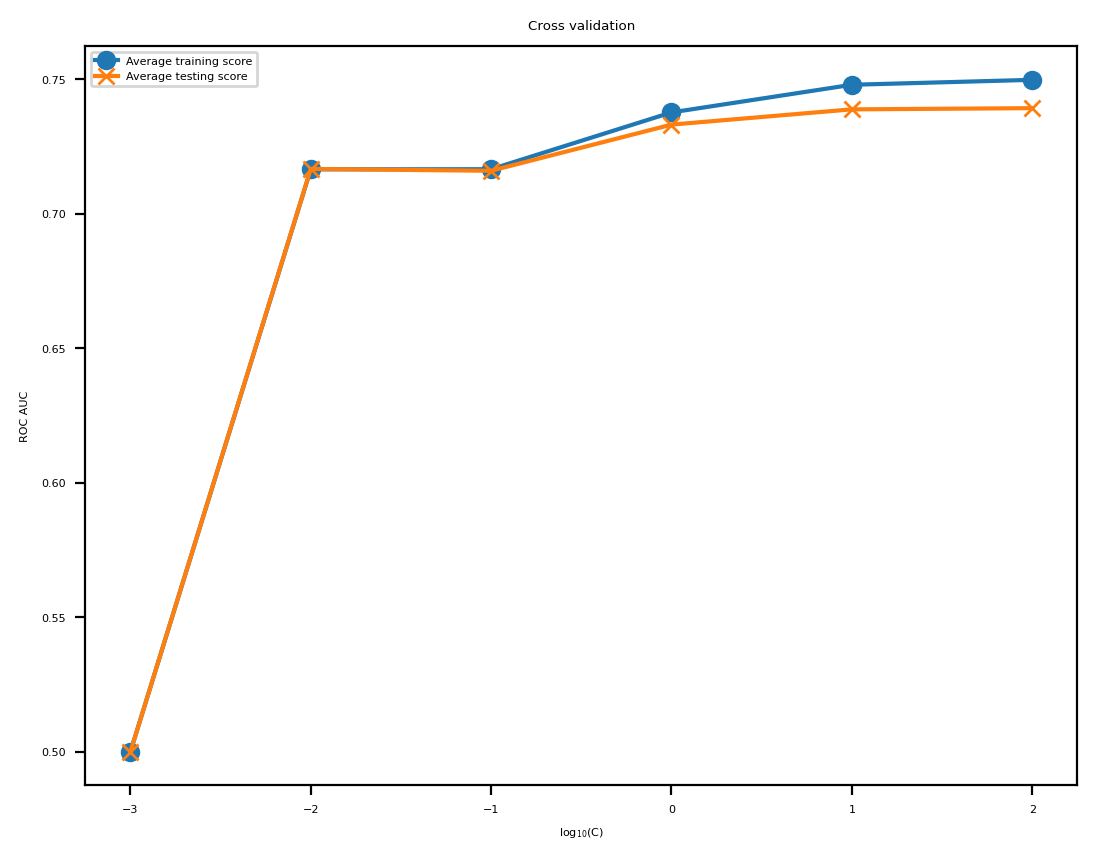

In [ ]:
# plotamos novamente os resultados
plt.plot(C_val_exponents, np.mean(cv_train_roc_auc, axis=0), '-o',
        label='Average training score')
plt.plot(C_val_exponents, np.mean(cv_test_roc_auc, axis=0), '-x',
        label='Average testing score')
plt.ylabel('ROC AUC')
plt.xlabel('log$_{10}$(C)')
plt.legend()
plt.title('Cross validation');

In [ ]:
np.mean(cv_test_roc_auc, axis=0)

array([0.73920672, 0.73876338, 0.73309533, 0.71593939, 0.71661851,
       0.5       ])

## Deu certo?

* A criação de características por engenharia melhorou a pontuação de teste para ROC_AUC = 0,74. (Anterior era 0,64)
* Esse resultado ocorre em C=100 (10² = log10(2))
* Vemos que na plotagem de pontuaçãoes de treinamento versus teste, vemos que a pontuação de treinamento é um pouco maior que a teste, o que indica um pequeno OVERFITTING, mas nada alarmante

* Será necessário explorarmos outros modelos para atender melhor ao cliente

## Modelo 3: Arvore de decisão


In [ ]:
# separar os dados em treino e teste
X_train, X_test, y_train, y_test = \
train_test_split(df[features_response[:-1]].values, df['default payment next month'].values,
test_size=0.2, random_state=24)

In [ ]:
dt = tree.DecisionTreeClassifier(max_depth=2) #no moemnto vamos utilizar um max_depth = 2
dt.fit(X_train, y_train)
dt.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 2,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': None,
 'splitter': 'best'}

In [ ]:
from sklearn.model_selection import GridSearchCV
# queremos encontrar a melhor profunidade máxima utilizando o max_depth

In [ ]:
X_train.shape

(21331, 17)

considerando que nossa amostra tem 21.331 linhas e uma validação cruzada com 4 folds:
    * haverá cerca de 3 quartos das amostras, ou seja L=16.000 amostras em cada fold.
    * Mas... Log2 (L) é o número aproximado de folhas e a profundidade, logo:
    * Log2(16000) =~ 14.
    * E portanto 14 é o número teorico da profundidade da árvore ideal. O que não é viavel na prática devido ao hiper-ajuste, portanto usaremos intervalos entre 1 a 12

In [ ]:
# utilizando parâmetros de 1 a 12
params = {'max_depth': [1,2,4,6,8,10,12]}

In [ ]:
cv = GridSearchCV(dt, param_grid=params, scoring='roc_auc',
                  n_jobs=None, refit=True, cv=4, verbose=1,
                  pre_dispatch=None, error_score=np.nan, return_train_score=True)
# utilizando o params_grid=params
# validação em 4 folds, cv=4

In [ ]:
cv.fit(X_train, y_train)
# tinhamos 4 folds e 7 hiperparametros, ou seja 7*4 = 28 ajustes.

Fitting 4 folds for each of 7 candidates, totalling 28 fits


GridSearchCV(cv=4, estimator=DecisionTreeClassifier(max_depth=2),
             param_grid={'max_depth': [1, 2, 4, 6, 8, 10, 12]},
             pre_dispatch=None, return_train_score=True, scoring='roc_auc',
             verbose=1)

In [ ]:
# examinando os resultados:
  # uma linha para cada combinação de hiperparametros
cv_results_df = pd.DataFrame(cv.cv_results_)
cv_results_df.sort_values('mean_test_score', ascending=False)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,mean_train_score,std_train_score
3,0.136552,0.000686,0.004203,0.000358,6,{'max_depth': 6},0.745252,0.746479,0.750630,0.740774,0.745784,0.003512,1,0.782202,0.780125,0.775228,0.774750,0.778076,0.003178
2,0.094408,0.004061,0.003867,0.000213,4,{'max_depth': 4},0.732720,0.740116,0.746946,0.743731,0.740878,0.005294,2,0.756882,0.752256,0.749368,0.753055,0.752890,0.002682
4,0.177767,0.004972,0.004890,0.000585,8,{'max_depth': 8},0.730004,0.732652,0.749747,0.729575,0.735495,0.008313,3,0.811837,0.808245,0.803554,0.802370,0.806502,0.003784
5,0.265326,0.032976,0.006331,0.001040,10,{'max_depth': 10},0.713211,0.706072,0.718099,0.709876,0.711814,0.004421,4,0.849578,0.853977,0.841430,0.836477,0.845365,0.006827
1,0.049908,0.001234,0.003940,0.000653,2,{'max_depth': 2},0.695134,0.699022,0.713376,0.699510,0.701761,0.006917,5,0.704034,0.702700,0.698113,0.702535,0.701845,0.002232
6,0.342012,0.011099,0.006530,0.000295,12,{'max_depth': 12},0.673786,0.657449,0.677640,0.681808,0.672671,0.009235,6,0.890031,0.903768,0.885370,0.875642,0.888703,0.010129
0,0.026016,0.000443,0.003932,0.000704,1,{'max_depth': 1},0.639514,0.643398,0.651891,0.650753,0.646389,0.005136,7,0.648680,0.647384,0.644553,0.644934,0.646388,0.001712


Vemos o maior mean test score em: 0.745784 (coluna 11)
vemos o max_depth = 6 com melhor resultado

Text(0, 0.5, 'ROC AUC')

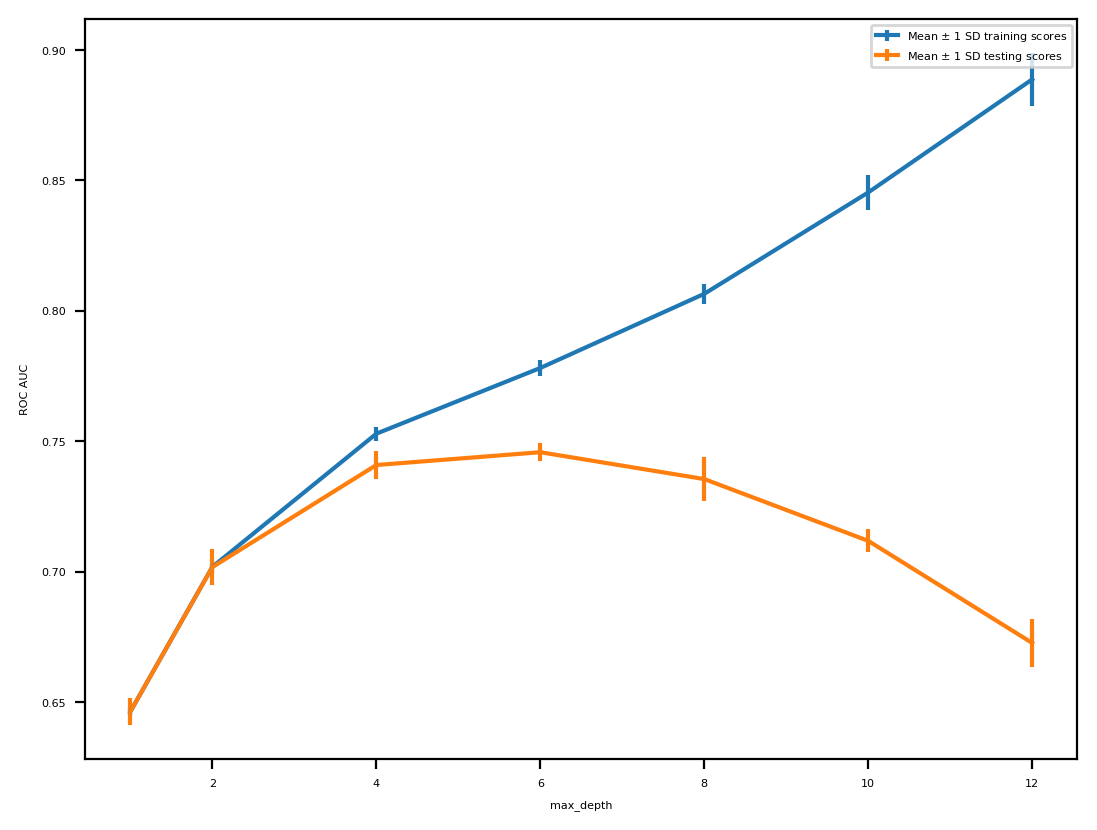

In [ ]:
# max_depth = 6 é a melhor opção para evitar over ou underfitting em dados de treno e teste.
ax = plt.axes()
ax.errorbar(cv_results_df['param_max_depth'],
            cv_results_df['mean_train_score'],
            yerr=cv_results_df['std_train_score'],
            label='Mean $\pm$ 1 SD training scores')
ax.errorbar(cv_results_df['param_max_depth'],
            cv_results_df['mean_test_score'],
            yerr=cv_results_df['std_test_score'],
            label='Mean $\pm$ 1 SD testing scores')
ax.legend()
plt.xlabel('max_depth')
plt.ylabel('ROC AUC');

## Deu certo?

* O nosso modelo encontrou um mean_roc_auc = 0,745, em max_depth = 6
* Nosso modelo de regressão logística havia encontrado 0.718 e, ajustado, 0.740.
* Tivemos uma melhoria pequena em relação a regressão logística ajustada, vamos experimentar outro modelo.

## Modelo 4: Floresta aleatória

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
# separar os dados em treino e teste
X_train, X_test, y_train, y_test = \
train_test_split(df[features_response[:-1]].values, df['default payment next month'].values,
test_size=0.2, random_state=24)

In [ ]:
# definir o modelo Radom_Forest com max_depth=3 e random_state=4 para o primeiro momento
rf = RandomForestClassifier(n_estimators=10, criterion='gini', max_depth=3,
                            min_samples_split=2, min_samples_leaf=1,min_weight_fraction_leaf=0.0,
                            bootstrap=True, oob_score=False,n_jobs=None,
                            random_state=4, verbose=0, warm_start=False,class_weight=None)

In [ ]:
#Utilizaremos esses max depths e n_estimators para teste no modelo
rf_params = {'max_depth':[3, 6, 9, 12],
             'n_estimators':[10, 50, 100, 200]}

In [ ]:
cv_rf = GridSearchCV(rf, param_grid=rf_params, scoring='roc_auc',
                  n_jobs=-1, refit=True, cv=4, verbose=2,
                  error_score=np.nan, return_train_score=True)

In [ ]:
cv_rf.fit(X_train, y_train) # treinando o modelo

Fitting 4 folds for each of 16 candidates, totalling 64 fits


GridSearchCV(cv=4,
             estimator=RandomForestClassifier(max_depth=3, n_estimators=10,
                                              random_state=4),
             n_jobs=-1,
             param_grid={'max_depth': [3, 6, 9, 12],
                         'n_estimators': [10, 50, 100, 200]},
             return_train_score=True, scoring='roc_auc', verbose=2)

* No resultado abaixo percebe-se que o melhor mean_test_score é de 0.776 (~0.78)
* Occore com max_depth = 9
* Ocorre com n_estimators = 200

In [ ]:
cv_rf.best_params_

{'max_depth': 9, 'n_estimators': 200}

In [ ]:
cv_rf_results_df= pd.DataFrame(cv_rf.cv_results_)
cv_rf_results_df.sort_values('mean_test_score', ascending=False)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,mean_train_score,std_train_score
11,14.612855,3.783157,0.308552,0.080996,9,200,"{'max_depth': 9, 'n_estimators': 200}",0.764963,0.767541,0.790255,0.782034,0.776199,0.010402,1,0.873807,0.874909,0.871185,0.871246,0.872787,0.001619
15,21.538060,5.447650,0.327852,0.144236,12,200,"{'max_depth': 12, 'n_estimators': 200}",0.765910,0.766963,0.785611,0.783513,0.775499,0.009101,2,0.945018,0.949378,0.946415,0.944689,0.946375,0.001851
10,9.893709,2.137355,0.190203,0.037981,9,100,"{'max_depth': 9, 'n_estimators': 100}",0.763872,0.765788,0.789016,0.781199,0.774969,0.010530,3,0.872099,0.874119,0.870537,0.871196,0.871988,0.001350
9,4.773454,1.046484,0.077056,0.025093,9,50,"{'max_depth': 9, 'n_estimators': 50}",0.763956,0.764420,0.786690,0.780255,0.773830,0.009908,4,0.867242,0.871380,0.868213,0.867390,0.868557,0.001672
14,7.412304,0.474377,0.151468,0.047207,12,100,"{'max_depth': 12, 'n_estimators': 100}",0.765665,0.765061,0.783413,0.781119,0.773815,0.008493,5,0.942902,0.946968,0.946109,0.942448,0.944607,0.001962
7,8.397690,1.170340,0.134319,0.002578,6,200,"{'max_depth': 6, 'n_estimators': 200}",0.761481,0.765319,0.787854,0.779745,0.773600,0.010682,6,0.808276,0.806853,0.800682,0.804006,0.804954,0.002906
6,4.194462,0.628181,0.078767,0.014245,6,100,"{'max_depth': 6, 'n_estimators': 100}",0.760964,0.765515,0.788793,0.778936,0.773552,0.011004,7,0.808194,0.806130,0.800846,0.803123,0.804573,0.002808
5,2.296740,0.490066,0.054111,0.024090,6,50,"{'max_depth': 6, 'n_estimators': 50}",0.760089,0.765251,0.788567,0.778669,0.773144,0.011193,8,0.807081,0.805109,0.799176,0.801229,0.803149,0.003113
13,3.597217,0.456481,0.062999,0.012085,12,50,"{'max_depth': 12, 'n_estimators': 50}",0.763750,0.763663,0.780781,0.778086,0.771570,0.007921,9,0.940170,0.943000,0.942297,0.937049,0.940629,0.002315
8,0.512012,0.014381,0.015829,0.001373,9,10,"{'max_depth': 9, 'n_estimators': 10}",0.757853,0.755444,0.781544,0.773823,0.767166,0.010899,10,0.854161,0.856197,0.850317,0.852039,0.853178,0.002211


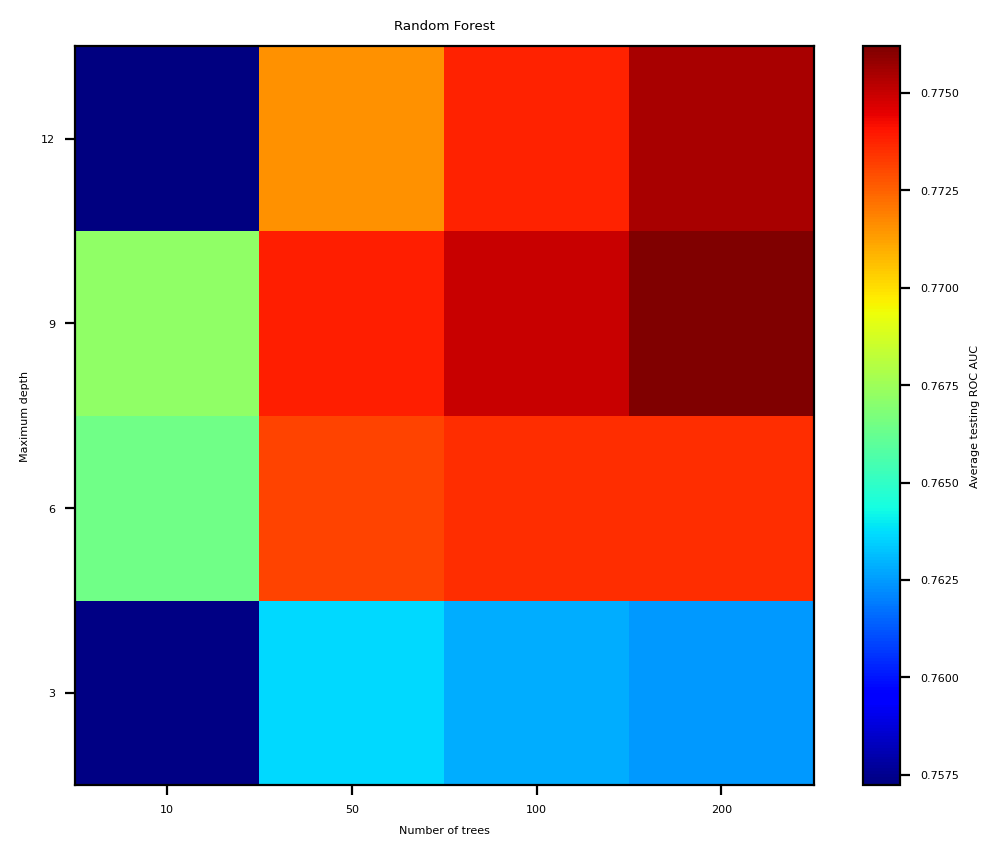

In [ ]:
# Poderíamos ver graficamente  a representação dos resultados da seguinte forma:
xx_rf, yy_rf = np.meshgrid(range(5), range(5))
cm_rf = plt.cm.jet
ax_rf = plt.axes()
pcolor_graph = ax_rf.pcolormesh(xx_rf, yy_rf, cv_rf_results_df['mean_test_score'].values.reshape((4,4)), cmap=cm_rf)
plt.colorbar(pcolor_graph, label='Average testing ROC AUC')
ax_rf.set_aspect('equal')
ax_rf.set_xticks([0.5, 1.5, 2.5, 3.5])
ax_rf.set_yticks([0.5, 1.5, 2.5, 3.5])
ax_rf.set_xticklabels([str(tick_label) for tick_label in rf_params['n_estimators']])
ax_rf.set_yticklabels([str(tick_label) for tick_label in rf_params['max_depth']])
ax_rf.set_xlabel('Number of trees')
ax_rf.set_ylabel('Maximum depth')
plt.title('Random Forest');

## Deu certo?

* Nosso modelo agora tem mean_test_roc_auc_score = 0.78, isto é, acertará as previsões em aproximadamente 80% das vezes

* Concluimos que o modelo é robusto e está pronto para distribuição para o cliente

# Conclusão

* Nesse notebook testamos várias abordagens para desenvolver um modelo de classificação binária que atenda aos requisitos empresariais do cliente

* Nossa conclusão é a de que um Modelo de Floresta Aleatória, com hiperparâmetros determinados na validação cruzada (200 arvores e max_depth=9) é o modelo que recomendamos